In [24]:
run run_residuals -o 1

 This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.




In [25]:
hidefigs = False
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
totalstars = np.sum(starsample.numstars.values())
allresids = np.ma.masked_array(np.zeros((totalstars,aspcappix)))
allsigmas = np.ma.masked_array(np.zeros((totalstars,aspcappix)))
i = 0
for subgroup in starsample.subgroups:
    match = np.where(starsample.data[starsample.subgroup]==subgroup)
    allresids[i:i+starsample.numstars[subgroup]] = starsample.residual[subgroup].T
    allsigmas[i:i+starsample.numstars[subgroup]] = starsample.errs[match]
    i += starsample.numstars[subgroup]

In [22]:
# Do EMPCA for each cluster individually
nvecs = 5
for subgroup in starsample.subgroups:
    print subgroup
    match = np.where(starsample.data[starsample.subgroup]==subgroup)
    empcaname = starsample.outName('pkl',content = 'empca',subgroup=subgroup,order = starsample.order,seed = starsample.seed,cross=starsample.cross)
    empcaname = empcaname.split('.pkl')[0]+'nvec{0}'.format(nvecs)+'.pkl'
    if os.path.isfile(empcaname):
        empcamodel,empcamodel_weight = acs.pklread(empcaname)
    elif not os.path.isfile(empcaname):
        mask = (starsample.residual[subgroup].mask.T==False)
        weights = mask.astype(int)
        weights[mask] = 1./starsample.errs[match][mask]**2 # Correct?
        empcamodel,runtime1 = timeIt(empca,starsample.residual[subgroup].T.data,weights = mask.astype(int))#,nvec=nvecs)
        print 'Runtime:', runtime1/60.,' min'
        #empcamodel_weight,runtime2 = timeIt(empca,starsample.residual[subgroup].T.data,weights = weights,nvec=nvecs)
        #print 'Runtime:', runtime2/60.,' min'
        #acs.pklwrite(empcaname,[empcamodel,empcamodel_weight])
    R2noise = 1 - np.ma.var(starsample.errs[match])/np.ma.var(starsample.residual[subgroup].T)
    R2 = np.zeros(nvecs)
    #R2_w = np.zeros(nvecs)
    for vec in range(nvecs):
        R2[vec] = empcamodel.R2(vec)
        #R2_w[vec] = empcamodel_weight.R2(vec)

    plt.figure()
    plt.plot(range(nvecs),R2,label='Unweighted EMPCA')
    #plt.plot(range(nvecs),R2_w,label='Weighted EMPCA')
    plt.axhline(R2noise,color='red',label='Noise Threshold')
    plt.xlabel('Number of eigenvectors')
    plt.ylabel('Variance')
    plt.legend(loc='best')
    plt.xlim(0,nvecs-1)
    plt.savefig('./{0}/empcaR2_{1}_order{2}_seed{3}_cross{4}_nvec{5}.png'.format(starsample.type,subgroup, starsample.order,starsample.seed,starsample.cross,nvecs))
    if hidefigs:
        plt.close()
        


M67
       iter        R2             rchi2
EMPCA  1/25              nan             nan


ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [27]:
empcaname = starsample.outName('pkl',content = 'empca',order = starsample.order,seed = starsample.seed,cross=starsample.cross)
empcaname = empcaname.split('pkl')[0]+'nvec{0}'.format(nvecs)+'.pkl'
if os.path.isfile(empcaname):
    empcamodel,empcamodel_weight = acs.pklread(empcaname)
elif not os.path.isfile(empcaname):
    mask = (allresids.mask==False)
    weights = mask.astype(int)
    weights[mask] = 1./allsigmas[mask]**2 # Correct?
    empcamodel,runtime1 = timeIt(empca,allresids,weights = mask.astype(int),nvec=nvecs)
    print 'Runtime:', runtime1/60.,' min'
    empcamodel_weight,runtime2 = timeIt(empca,allresids,weights = weights,nvec=nvecs)
    print 'Runtime:', runtime2/60.,' min'
    acs.pklwrite(empcaname,[empcamodel,empcamodel_weight])

       iter        R2             rchi2
EMPCA  1/25       0.01692896      0.00453127
EMPCA  2/25       0.66347058      0.00154661
EMPCA  3/25       0.47495173      0.00241644
EMPCA  4/25       0.78374318      0.00099341
EMPCA  5/25       0.58980960      0.00188186
EMPCA  6/25       0.66029065      0.00156138
EMPCA  7/25       0.65525315      0.00158267
EMPCA  8/25       0.91511255      0.00038971
EMPCA  9/25       0.94474708      0.00025371
EMPCA 10/25       0.95023567      0.00022843
EMPCA 11/25       0.95134297      0.00022336
EMPCA 12/25       0.95344827      0.00021368
EMPCA 13/25       0.95575310      0.00020307
EMPCA 14/25       0.95995431      0.00018376
EMPCA 15/25       0.96326614      0.00016855
EMPCA 16/25       0.96502814      0.00016045
EMPCA 17/25       0.96583602      0.00015674
EMPCA 18/25       0.96620943      0.00015502
EMPCA 19/25       0.96654628      0.00015347
EMPCA 20/25       0.96659057      0.00015327
EMPCA 21/25       0.96686816      0.00015200
EMPCA 22/25    

In [28]:
R2noise = 1 - np.ma.var(allsigmas)/np.ma.var(allresids)
R2 = np.zeros(nvecs)
R2_w = np.zeros(nvecs)
for vec in range(nvecs):
    R2[vec] = empcamodel.R2(vec)
    R2_w[vec] = empcamodel_weight.R2(vec)

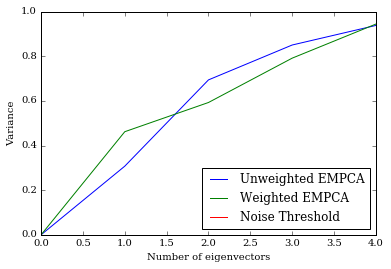

In [29]:
plt.figure()
plt.plot(range(nvecs),R2,label='Unweighted EMPCA')
plt.plot(range(nvecs),R2_w,label='Weighted EMPCA')
plt.axhline(R2noise,color='red',label='Noise Threshold')
plt.xlabel('Number of eigenvectors')
plt.ylabel('Variance')
plt.legend(loc='best')
plt.xlim(0,nvecs-1)
plt.savefig('./{0}/empcaR2_order{1}_seed{2}_cross{3}_nvec{4}.png'.format(starsample.type, starsample.order,starsample.seed,starsample.cross,nvecs))
if hidefigs:
    plt.close()